<div style="display: flex; text-align:center; background-color: rgb(1,120,153);" >
<h1 style="margin: auto; padding: 30px; ">Détectez des faux billets avec R ou Python <br>
</h1>
</div>

<div style="display: flex; text-align:center; background-color: rgb(1,120,153);" >
<h1 style="margin: auto; padding: 30px; ">Partie 1 - Exploration / Nettoyage <br>
</h1>
</div>

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">1 - Importation des librairies,fichier et des fonctions</h2>
</div>

In [2]:
# importation des librairies utiles
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy.stats as st
#import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,classification_report, accuracy_score
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importation du fichier csv
billets = pd.read_csv("billets.csv",sep=';')

In [3]:
def backward_selected(data, response):
    """Linear model designed by backward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by backward selection
           evaluated by parameters p-value
    """
    remaining = set(data._get_numeric_data().columns)
    if response in remaining:
        remaining.remove(response)
    cond = True

    while remaining and cond:
        formula = "{} ~ {} + 1".format(response,' + '.join(remaining))
        print('_______________________________')
        print(formula)
        model = smf.ols(formula, data).fit()
        score = model.pvalues[1:]
        toRemove = score[score == score.max()]
        if toRemove.values > 0.05:
            print('remove', toRemove.index[0], '(p-value :', round(toRemove.values[0],3), ')')
            remaining.remove(toRemove.index[0])
        else:
            cond = False
            print('is the final model !')
        print('')
    print(model.summary())
    
    return model


<div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">2 - Nettoyage </h2>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.1- Exploration du dataframe </h3>
</div> 

In [4]:
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [5]:
billets.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


In [6]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64


 - Notre dataframe est composé 1500 lignes, 7 variables, 6 variables quantitative et une variable booléenne.
 - On remarque aussi que le df possède 37 valeurs manquantes pour la variable margin_low.

In [7]:
billets.loc[billets['margin_low'].isna()].head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36
251,True,171.80,103.26,102.82,NaN,2.95,113.22
284,True,171.92,103.83,103.76,NaN,3.23,113.29
334,True,171.85,103.70,103.96,NaN,3.00,113.36
410,True,172.56,103.72,103.51,NaN,3.12,112.95
413,True,172.30,103.66,103.50,NaN,3.16,112.95


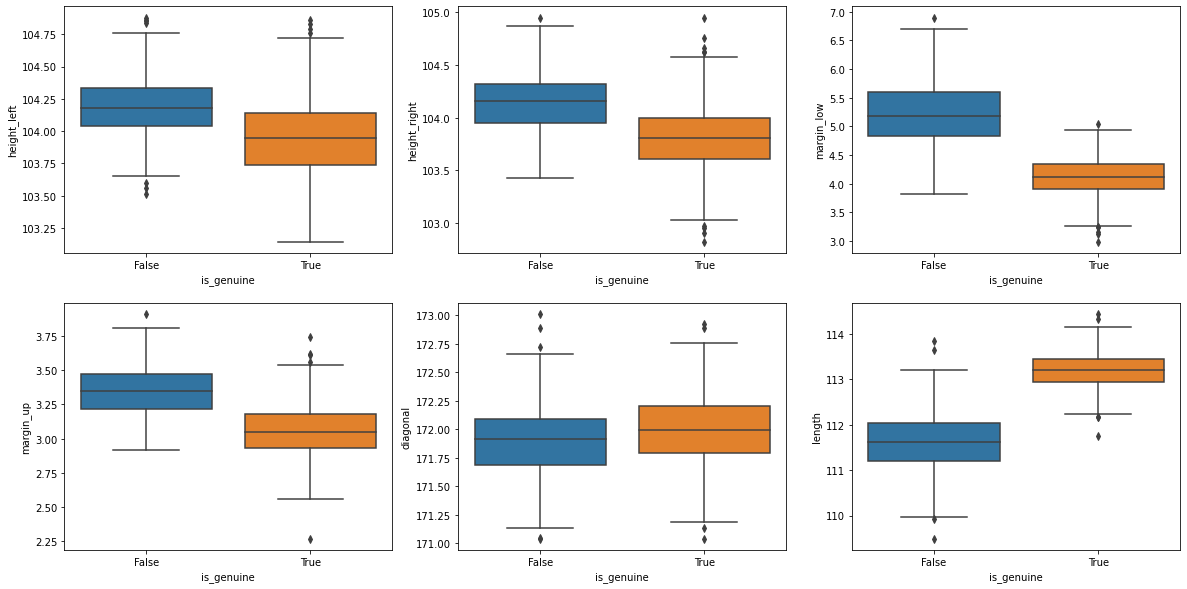

In [8]:
# boxplot de distribution des variables par rapport a la variables 'is_genuine'
plt.figure(figsize=(20, 10))
variables = billets.columns[1:]
plt.subplot(231)
sns.boxplot(x='is_genuine', y='height_left', data=billets)
plt.subplot(232)
sns.boxplot(x='is_genuine', y='height_right', data=billets)
plt.subplot(233)
sns.boxplot(x='is_genuine', y='margin_low', data=billets)
plt.subplot(234)
sns.boxplot(x='is_genuine', y='margin_up', data=billets)
plt.subplot(235)
sns.boxplot(x='is_genuine', y='diagonal', data=billets)
plt.subplot(236)
sns.boxplot(x='is_genuine', y='length', data=billets)
plt.show()

 - les variables margin et height ont des mediane plus élevées pour les faux billets.
 - la variable length a une médiane plus basse pour les faux billets.
 - la variable diagonal ne semble pas avoir de signification sur le type de billet.

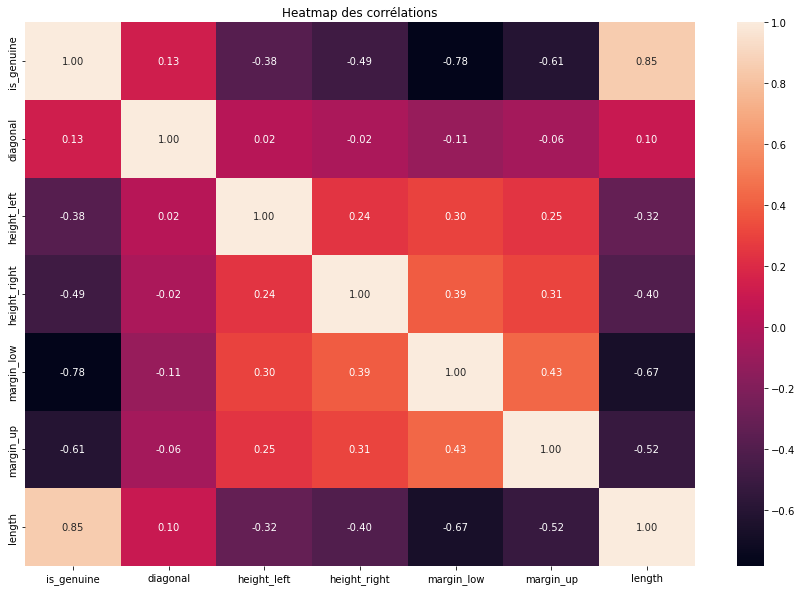

In [9]:
#HeatMap des corrélations linéaires 
plt.figure(figsize=(15, 10))
sns.heatmap(billets.corr(), annot=True, fmt=".2f")
plt.title('Heatmap des corrélations')
plt.show()

Ce heat map confirme l'impact de la longueur et de la marge basse sur l'authenticité. On dit donc si un le faite qu'un billets soit vrais et corrélé positivement a la longueur que la véracité du billet est corrélée positivement à la longueur, et négativement à la marge basse. Les variables ont toutes des dépendances plus ou moins marquées avec les autres, à part dans une moindre mesure la diagonale.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.2- Imputation des valeurs manquantes par régression linéaire multiple </h3>
</div> 

On enleve les valeurs manquantes afin d'etudier les corrélation entre les differentes variables

In [10]:
df = billets.copy()
df_isna = df[df["margin_low"].isna()]
df_isnotna = df.dropna()

In [11]:
df_isna.head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,NaN,3.25,112.79
99,True,171.93,104.07,104.18,NaN,3.14,113.08
151,True,172.07,103.80,104.38,NaN,3.02,112.93
197,True,171.45,103.66,103.80,NaN,3.62,113.27
241,True,171.83,104.14,104.06,NaN,3.02,112.36


In [12]:
df_isnotna.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [13]:
df_isnotna = df.dropna()
df_reg_multi = df_isnotna
df_reg_multi.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [14]:
columns = df_reg_multi.columns
reg_backward = backward_selected(df_reg_multi[columns], 'margin_low')

_______________________________
margin_low ~ is_genuine + diagonal + height_left + length + height_right + margin_up + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ is_genuine + diagonal + height_left + height_right + margin_up + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ is_genuine + height_left + height_right + margin_up + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ is_genuine + height_left + margin_up + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

On retire au fur et a mesure les variables non significative c'est a dire que leur pvalue n'est pas inférieur a 5%

On réitére plusieurs fois tout en enlevant la variable qui est le moins significatives a chaque fois jusqu'a trouvé des pvalues inferieur a 5%

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.3- Test de normalité des résidus </h3>
</div>

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [15]:
from scipy.stats import t, shapiro
shapiro(reg_backward.resid)

ShapiroResult(statistic=0.9936248064041138, pvalue=6.20942773821298e-06)

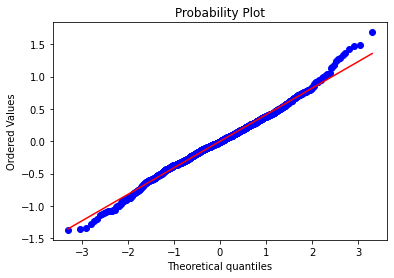

In [16]:
st.probplot(reg_backward.resid, dist="norm", plot=plt);

L'hypothèse de normalité est remise en cause, cependant, avec le nombre d'observations que nous avons, nous pouvons nous passer de cette hypothèse.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 10px; color: RGB(51,165,182); ">2.4- Prediction des valeurs manquantes </h3>
</div>


In [17]:
a_predire = df_isna
margin_low_pred_reg_multi = reg_backward.predict(a_predire)
margin_low_pred_reg_multi.head(10)

72     4.074248
99     4.097561
151    4.122994
197    3.995830
241    4.122994
251    4.137830
284    4.078487
334    4.127233
410    4.101800
413    4.093322
dtype: float64

On remplace les valeurs nulles par les valeurs prédites grâce à la régression linéaire multiple.



In [18]:
billets.loc[billets["margin_low"].isnull(), 'margin_low'] = margin_low_pred_reg_multi

In [19]:
billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<div style="display: flex; text-align:center; background-color: rgb(1,120,153);" >
<h1 style="margin: auto; padding: 30px; ">Partie 2 - Analyse des méthode de prédictions <br>
</h1>
</div>

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">1- ACP</h2>
</div>


In [20]:
df = billets.copy()
df.sample(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
978,True,172.43,103.65,104.3,4.09,2.94,113.06


In [21]:
X = df.drop('is_genuine',axis=1)
Y = df['is_genuine']
print(X.sample())
print(Y.sample(2))

     diagonal  height_left  height_right  margin_low  margin_up  length
634     172.2       103.93        103.49         3.8       2.99  113.63
1404    False
265      True
Name: is_genuine, dtype: bool


In [22]:
# Normalisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

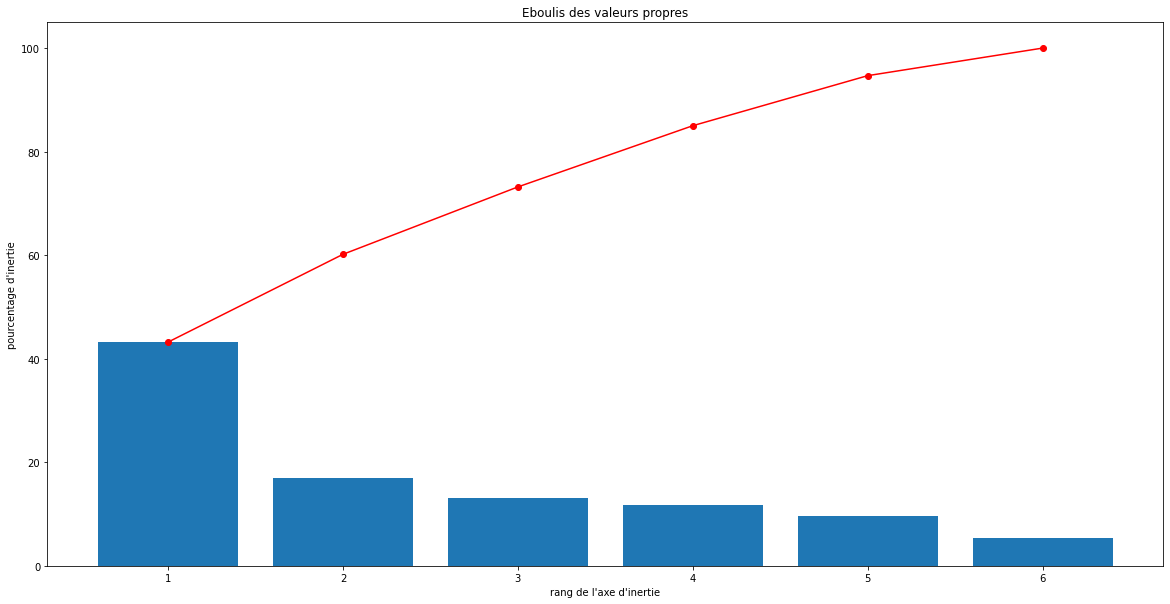

In [23]:
#Représentation de la variance expliquée 
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    

plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

In [24]:
#Pourcentage de variance expliquée par les composantes principales à l'aide de .explained_variance_ratio_
print(pca.explained_variance_ratio_.cumsum())

[0.43204935 0.60162072 0.73182015 0.85007198 0.9467411  1.        ]


Le diagramme des éboulis précise une représentation satisfaisante de nos variables sur les deux premières composantes principales, le premier axe factoriel ( 60 % )

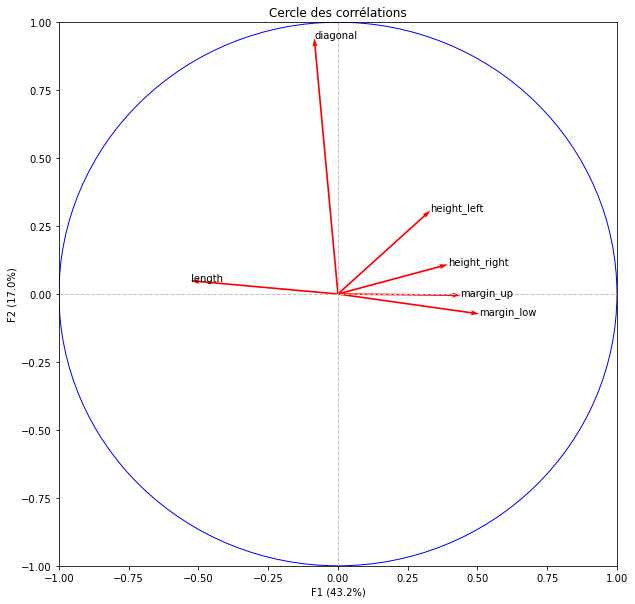

In [25]:
#Calcul des composantes principales sur les deux premières
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, billets.iloc[:,1:].columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.show()

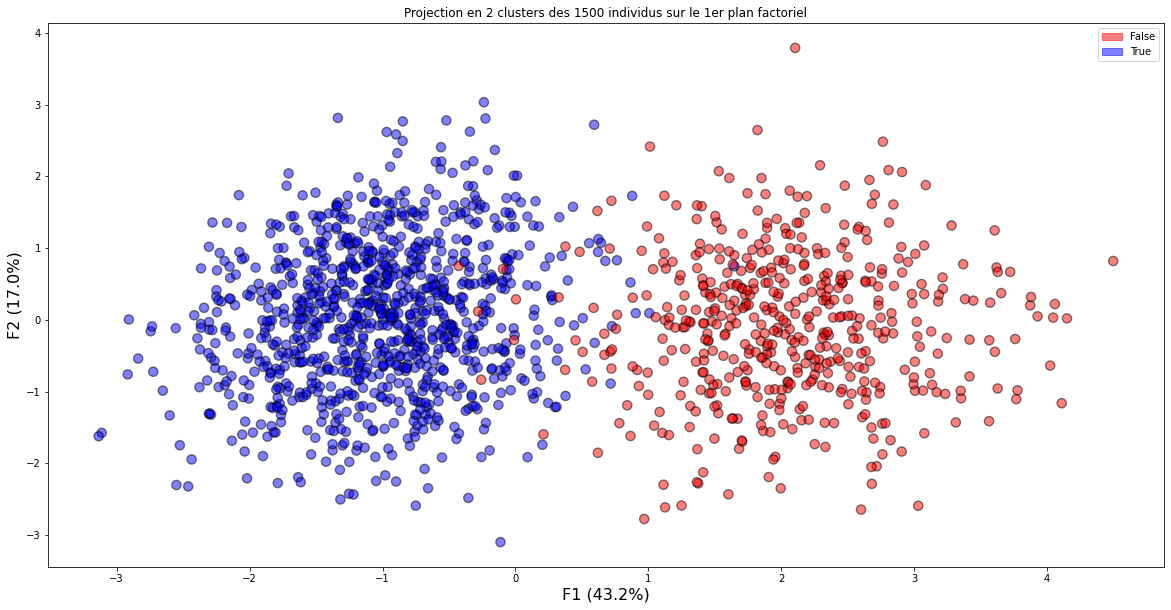

In [26]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))

#Projection des indivifus par scatter Plot sur le premier plan factoriel
colors = ['red', 'blue']
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=Y.apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)

#Labels de la nature des billets
lab_0 = mpatches.Patch(color='red', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize=16)
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize=16)
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))
plt.show()

In [27]:
X.columns[()]

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [28]:
#Coefficients de la composante principale F1
F1 = pca.components_[0]
print(F1) 
#Coefficients de la composante principale F2
F2 = pca.components_[1]
print(F2)

[-0.08483969  0.33133251  0.39376123  0.50658472  0.43931716 -0.52758454]
[ 0.94130571  0.30725488  0.10859729 -0.07316255 -0.00442827  0.04870577]


 A partir de ces représentation graphique, nous pouvons déterminer les variables qui se révélent être les plus corrélées aux composantes F1 et F2. Notons également que la longueur des flèches est importante, une variable dont la longueur de la flèche est proche de 1 sera extrêmement bien représentée.

  - La variable lenght contribue négativement à l'axe F1.
  
  - La variable diagonal contribue fortement (et positivement) à l'axe F2

  - Les variables height_left et height_right contribuent le plus et positivement à l'axe F1.

  - Les variables margin_up et margin_low contribuent positivement à l'axe F1.
  
F2 est representative de la diagonale

F1 est représentative de toutes les autres variables

 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">2- Kmeans</h2>
</div>


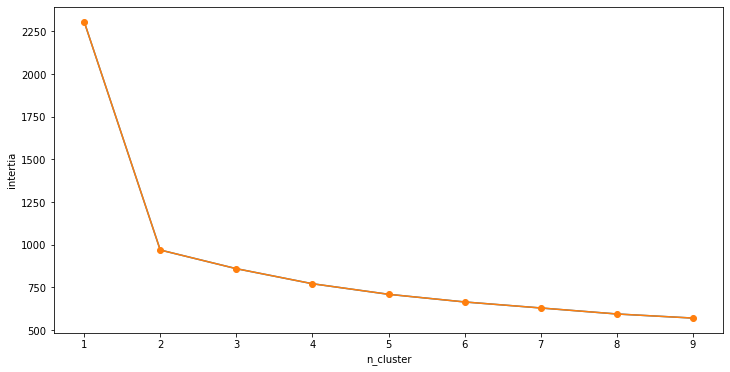

In [29]:
from sklearn import datasets
from sklearn.cluster import KMeans

# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

# Notre liste de nombres de clusters : 
k_list = range(1, 10)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k)
    
    # On entraine
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(12,6))

ax.set_ylabel("intertia")
ax.set_xlabel("n_cluster")

ax = plt.plot(k_list, intertia_list)
plt.plot(range(1, 10), intertia_list, marker='o')
plt.show()

Grâce a la methode de coude, on observe une cassure dans la courbe a n_cluster = 2, nous allons donc réaliser un clusturing a 2 cluster

In [29]:
#Classification des billets pour un K-Means  a 2 clusters 
cls2 = KMeans(n_clusters=2)
cls2 = cls2.fit(X)

In [30]:
cls2_pred = cls2.predict(X)
cls2_pred

array([0, 0, 0, ..., 1, 1, 1])

In [31]:
cls2_pred

array([0, 0, 0, ..., 1, 1, 1])

In [32]:
#Intégration des clusters dans notre dataframe "df_cls" par la méthode .concat()
df_cls2 = pd.DataFrame(cls2_pred, columns=['cluster'])
df_cls2 = pd.concat([df_cls2, billets], axis=1)
df_cls2.head(30)

,cluster,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.46,103.36,103.66,3.77,2.99,113.09
2,0,True,172.69,104.48,103.50,4.40,2.94,113.16
3,0,True,171.36,103.91,103.94,3.62,3.01,113.51
4,0,True,171.73,104.28,103.46,4.04,3.48,112.54
5,0,True,172.17,103.74,104.08,4.42,2.95,112.81
6,0,True,172.34,104.18,103.85,4.58,3.26,112.81
7,0,True,171.88,103.76,104.08,3.98,2.92,113.08
8,0,True,172.47,103.92,103.67,4.00,3.25,112.85
9,0,True,172.47,104.07,104.02,4.04,3.25,113.45


Avec la visualisation ci-dessus, on peut determiner qu'elle cluster est True en recuperant les 30 premiers lignes de chaque variable et en les comparant

On remarque que le cluster 0 correspond a la valeur True de is_genuine

In [33]:
#Tableau des correspondances clusters/nature billets
tableau = pd.crosstab(cls2.labels_,df_cls2['is_genuine'])
tableau.index = ['0','1']
tableau

is_genuine,False,True
0,19,998
1,481,2


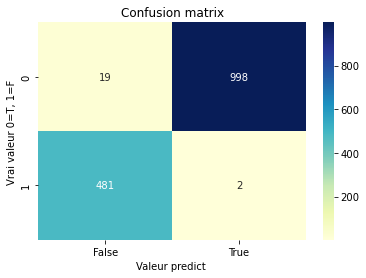

In [34]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(tableau), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Vrai valeur 0=T, 1=F')
plt.xlabel('Valeur predict ')
plt.show()

On rappel ici que :
 - 0 = True
 - 1 = False
 
Le model de prediction Kmean a trouvé : 
 - 998/1000 billets Vrai/Vrai
 - 481/500 billets Faux/Faux
 - 2/1000 billets Vrai/Faux
 - 19/500 billets Faux/Vrai
 
On remarque que le Kmean ce trompe sur 21 billets.

Nous allons maintenant essayé la prédiction par régression logistique pour essayer de comparer les deux méthodes et voir laquelle est la plus précise


 <div style="background-color: RGB(51,165,182);" >
<h2 style="margin: auto; padding: 20px; color:#fff; ">3- Régression logistique</h2>
</div>

In [39]:
X_train , X_test , y_train , y_test = train_test_split (X,Y, test_size = 0.2)
# Construction du model
model_reg = LogisticRegression()
model_reg = model_reg.fit(X_train,y_train)

In [40]:
model_reg_predict = model_reg.predict(X_test)
accuracy_score(model_reg_predict,y_test)

0.9966666666666667

In [41]:
metrix = classification_report(y_test, model_reg_predict)
print(metrix)

              precision    recall  f1-score   support

       False       1.00      0.99      0.99        96
        True       1.00      1.00      1.00       204

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300



In [42]:
tab = pd.crosstab(model_reg_predict,y_test,margins=True,margins_name = 'Total')
confusion_matrix_reg =  pd.crosstab(model_reg_predict,y_test)
tab

is_genuine,False,True,Total
row_0,,,
False,95,0,95
True,1,204,205
Total,96,204,300


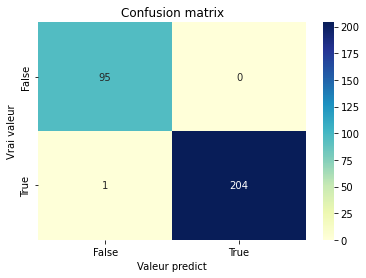

In [43]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(confusion_matrix_reg, annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix')
plt.ylabel('Vrai valeur')
plt.xlabel('Valeur predict')
plt.show()


 
Le modèle de prediction avec la régression logistique a trouvé : 
 - 204/205 Vrai/Vrai billets
 - 95/95 Faux/Faux billets
 - 1/205  Vrai/Faux billets
 - 0/95  Faux/Vrai billets

Au vue des données recolté après prediction et de sa précision, la prédiction avec la régression logistique sera préviligié.

Nous allons donc utilisé notre modèle pour crée un algorithme permettant de detecter les faux billets

<div style="display: flex; text-align:center; background-color: rgb(1,120,153);" >
<h1 style="margin: auto; padding: 30px; ">Partie 3 - Algorithme de prédiction faux billets  <br>
</h1>
</div>

Nous allons donc choisir la régression logistique car sa précision de détéction est de 99% 

In [44]:
def prediction(fichier_test):
    # defini le df
    data = pd.read_csv(fichier_test)
    
    # def X_test
    X_test = data.iloc[:, :-1]
    
    # resultat du model
    reg_log_pred = model_reg.predict(X_test)
    reg_log_prob_true = model_reg.predict_proba(X_test)[:,1]
    reg_log_prob_false = model_reg.predict_proba(X_test)[:,0]
    
    # Creation des colonnes 
    data["is_genuine_pred"] = reg_log_pred
    data['proba true'] = reg_log_prob_true
    data['proba false'] = reg_log_prob_false
    
    # Résultat
    return(data[['diagonal','height_left','height_right','margin_low','margin_up','length','id',  'is_genuine_pred','proba true','proba false']].set_index('id'))

In [45]:
prediction('billets_production.csv')


,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_pred,proba true,proba false
id,,,,,,,,,
A_1,171.76,104.01,103.54,5.21,3.30,111.42,False,0.005357,0.994643
A_2,171.87,104.17,104.13,6.00,3.31,112.09,False,0.000925,0.999075
A_3,172.00,104.58,104.29,4.99,3.39,111.57,False,0.001437,0.998563
A_4,172.49,104.55,104.34,4.44,3.03,113.20,True,0.915597,0.084403
A_5,171.65,103.63,103.56,3.77,3.16,113.33,True,0.999584,0.000416


In [47]:
prediction('billets_test.csv')

,diagonal,height_left,height_right,margin_low,margin_up,length,is_genuine_pred,proba true,proba false
id,,,,,,,,,
B_1,172.09,103.95,103.73,4.39,3.09,113.19,True,0.988598,0.011402
B_2,171.52,104.17,104.03,5.27,3.16,111.82,False,0.009296,0.990704
B_3,171.78,103.80,103.75,3.81,3.24,113.39,True,0.999053,0.000947
B_4,172.02,104.08,103.99,5.57,3.30,111.10,False,0.000167,0.999833
B_5,171.79,104.34,104.37,5.00,3.07,111.87,False,0.014582,0.985418
